<a href="https://www.kaggle.com/code/kusumakar/car-price-eda-and-prediction-0-51-r2-score?scriptVersionId=203878981" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cars-dataset/Cars dataset.csv


In [2]:
df=pd.read_csv("/kaggle/input/cars-dataset/Cars dataset.csv")

In [3]:
df.head()

,brand,km_driven,fuel,owner,selling_price
0,Maruti,145500,Diesel,First Owner,450000
1,Skoda,120000,Diesel,Second Owner,370000
2,Honda,140000,Petrol,Third Owner,158000
3,Hyundai,127000,Diesel,First Owner,225000
4,Maruti,120000,Petrol,First Owner,130000


In [4]:
df.isnull().sum()

brand            0
km_driven        0
fuel             0
owner            0
selling_price    0
dtype: int64

In [5]:
df.shape

(8128, 5)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

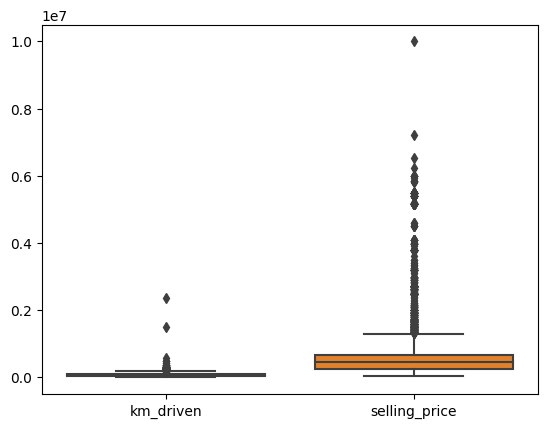

In [7]:
sns.boxplot(df)

In [8]:
Q1 = df['selling_price'].quantile(0.25)
Q3 = df['selling_price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['selling_price'] >= lower_bound) & (df['selling_price'] <= upper_bound)]

In [9]:
Q1 = df['km_driven'].quantile(0.25)
Q3 = df['km_driven'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
clean_df = df[(df['km_driven'] >= lower_bound) & (df['km_driven'] <= upper_bound)]

<Axes: xlabel='brand', ylabel='selling_price'>

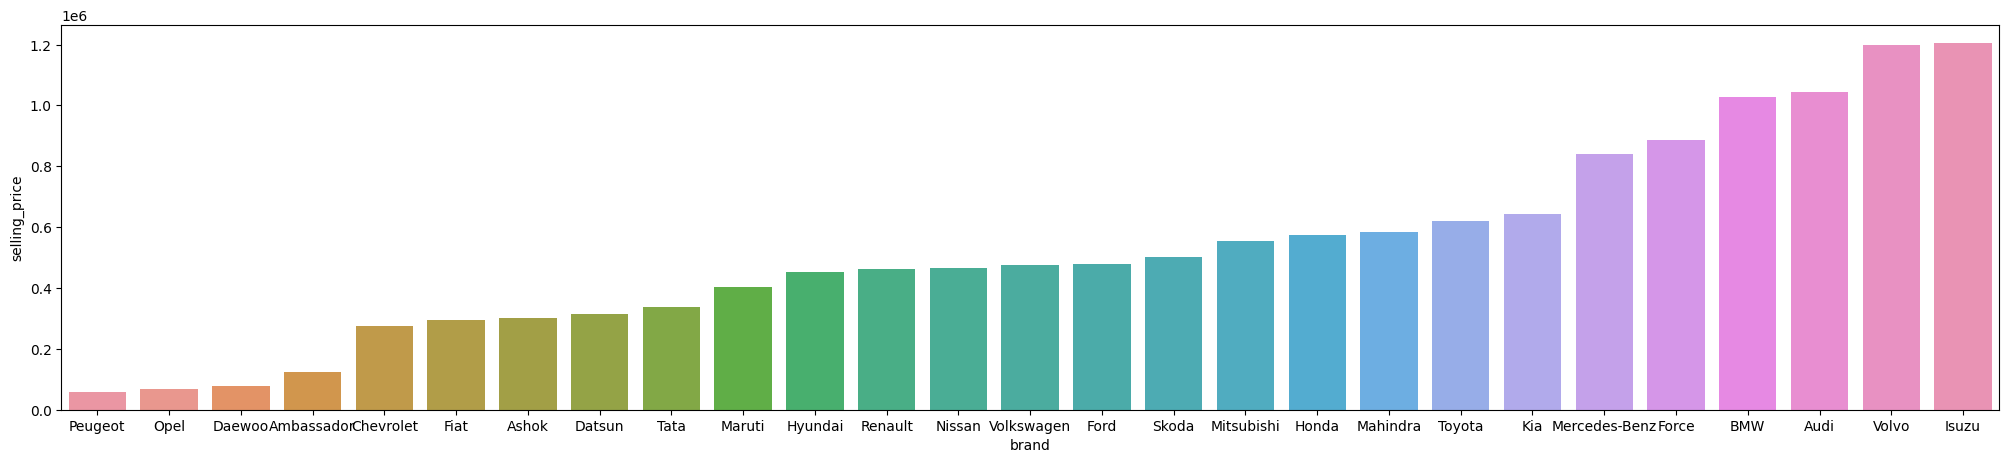

In [10]:
df1=df.groupby('brand').agg({"selling_price":"mean"}).reset_index().sort_values(by='selling_price')
plt.figure(figsize=(25,5))

sns.barplot(x='brand',y='selling_price',data=df1)

<Axes: xlabel='fuel', ylabel='selling_price'>

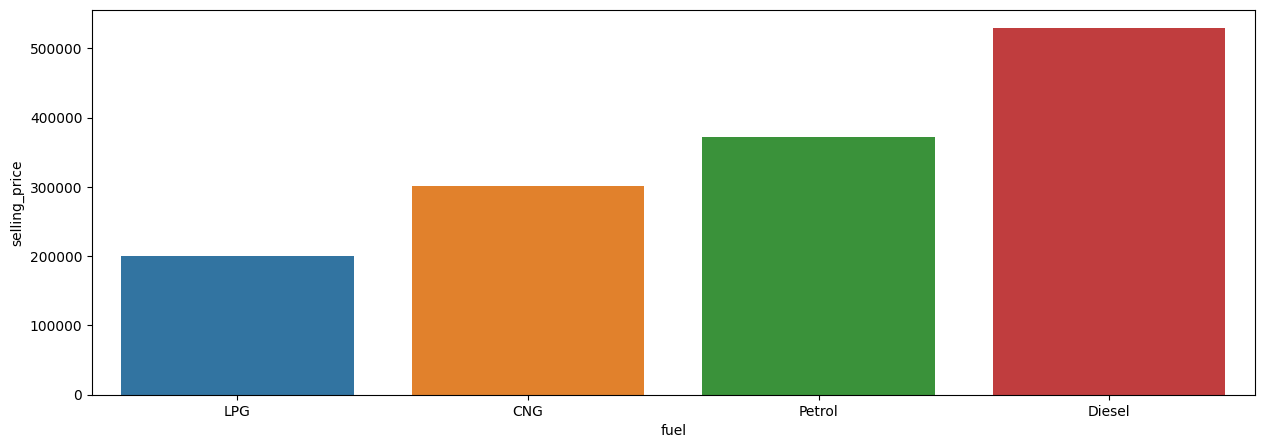

In [11]:
df1=df.groupby('fuel').agg({"selling_price":"mean"}).reset_index().sort_values(by='selling_price')
plt.figure(figsize=(15,5))

sns.barplot(x='fuel',y='selling_price',data=df1)

<Axes: xlabel='owner', ylabel='selling_price'>

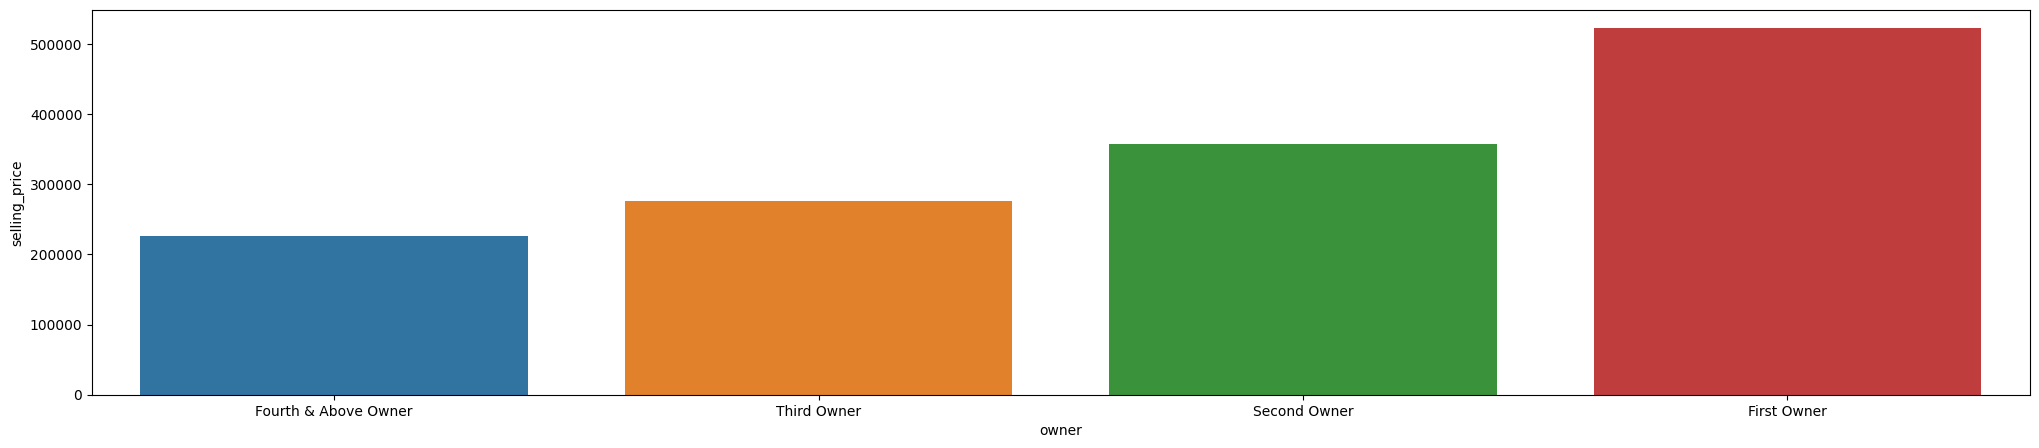

In [12]:
df1=df.groupby('owner').agg({"selling_price":"mean"}).reset_index().sort_values(by='selling_price')
plt.figure(figsize=(25,5))

sns.barplot(x='owner',y='selling_price',data=df1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


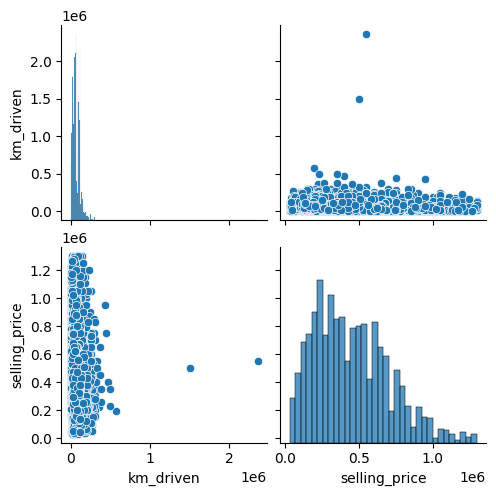

In [13]:
sns.pairplot(df[['km_driven','selling_price']])

<Axes: >

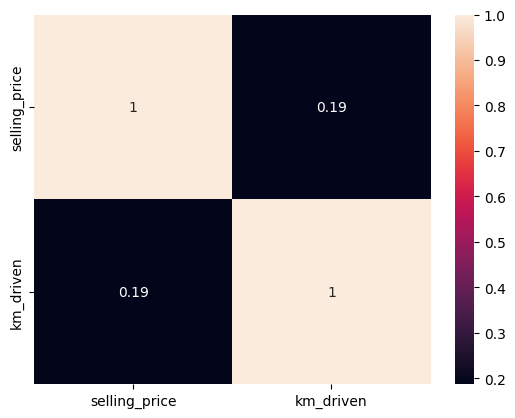

In [14]:
sns.heatmap(df[['selling_price','km_driven']].corr().abs(),annot=True)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer

In [16]:
X=df.drop(columns=['selling_price'])
Y=df['selling_price']

In [17]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25)

In [18]:
X_train

,brand,km_driven,fuel,owner
848,Maruti,107000,Diesel,First Owner
936,Maruti,90000,Petrol,Second Owner
3906,Hyundai,49000,Diesel,First Owner
1185,Toyota,80000,Diesel,First Owner
2019,Maruti,40000,Petrol,First Owner
...,...,...,...,...
521,Maruti,30000,Petrol,First Owner
6740,Nissan,110000,Diesel,Third Owner
5799,Hyundai,70000,Petrol,Second Owner
4135,Maruti,120000,Diesel,Third Owner


In [19]:
fuel_encoder = OrdinalEncoder(categories=[['LPG','CNG','Petrol','Diesel']])
owner_encoder = OrdinalEncoder(categories=[['Fourth & Above Owner','Third Owner' ,'Second Owner','First Owner']])
X_train['fuel']=fuel_encoder.fit_transform(X_train[['fuel']])
X_test['fuel']=fuel_encoder.transform(X_test[['fuel']])
X_train['owner']=owner_encoder.fit_transform(X_train[['owner']])
X_test['owner']=owner_encoder.fit_transform(X_test[['owner']])

In [20]:
transformer  = ColumnTransformer(
[
    ("scaler",StandardScaler(),['km_driven']),
    ("Encoder",OneHotEncoder(),['brand'])
],remainder='passthrough')

In [21]:
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

In [22]:
X_train_transformed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 22412 stored elements and shape (5646, 30)>

In [23]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
models = {"Random Forest Regressor":RandomForestRegressor(),
         "Decision Tree Regressor":DecisionTreeRegressor(),
         "Linear Regressor":LinearRegression(),
         "XGBoost Regression":XGBRegressor(),
         }

In [24]:
r2_scores=[]
mean_squared = []
mean_absolute = []
model_list =[]
for model_name,model in models.items():
    model.fit(X_train_transformed,Y_train)
    ypred = model.predict(X_test_transformed)
    r2_scores.append(r2_score(Y_test,ypred))
    mean_squared.append(mean_squared_error(Y_test,ypred))
    mean_absolute.append(mean_absolute_error(Y_test,ypred))
    model_list.append(model_name)

In [25]:
accuracy_data = pd.DataFrame()
accuracy_data['Model ']=model_list
accuracy_data['R2 Score']=r2_scores



accuracy_data

,Model,R2 Score
0,Random Forest Regressor,0.488004
1,Decision Tree Regressor,0.390663
2,Linear Regressor,0.401753
3,XGBoost Regression,0.522256
